# DOcplex Çalıştırırken Modelin İzlenmesi (Listeners) #
Bir optimizasyon modeli eğer kısa sürede çözüm üretiyosa bu modeli izlemeye gerek yoktur. Fakat optimum noktayı bulması zaman alıyorsa ve süreci takip etmek gerekiyorsa, modelin izlenmesi gerekir. IBM CPLEX OPL Studio'da modeli çalıştırdığınızda __Engine Log__ sekmesinde modelin adımlarını takip edebilirsiniz. Fakat DOCplex'de takip etmek için farklı kütüphaneleri import etmeniz gerekmektedir.

Bu eğitimde, bir optimizasyon modelini DOcplex'de çalıştırırken nasıl izleyeceğiniz anlatılacaktır. Eğitim içeriği <a href="https://github.com/IBMDecisionOptimization/docplex-examples/blob/f540bccbaf552bca0fe4a1fb13a33aaceef72588/examples/mp/jupyter/progress.ipynb">bu linkteki notebook</a> faydalınalarak hazırlanmıştır.

## Modelin Oluşturulması ##
DOcplex'de bir modeli izlemek için öncelikle yorucu bir model oluşturmamız gerekiyor. Bunun için girdiye göre büyüyen bir model oluşturulmuştur. Model için iki boyutlu bir binary karar değişkenimiz var. Bu karar değişkenimiz verilen kısıtlara göre 2 indisli koordinat sisteminde kalp oluşturacak çözüm kümesini bulmaya çalışıyor. 

Yazdığımız modeli bir fonksiyona atıyoruz ve bu fonksiyon kaça kaçlık bir matris olacağını parametre ile dışardan almaktadır.

In [1]:
from docplex.mp.model import Model

def build_hearts(r, **kwargs):
    # initialize the model
    mdl = Model('love_hearts_%d' % r, **kwargs)

    # the dictionary of decision variables, one variable
    # for each circle with i in (1 .. r) as the row and
    # j in (1 .. i) as the position within the row    
    idx = [(i, j) for i in range(1, r + 1) for j in range(1, i + 1)]
    a = mdl.binary_var_dict(idx, name=lambda ij: "a_%d_%d" % ij)

    # the constraints - enumerate all equilateral triangles
    # and prevent any such triangles being formed by keeping
    # the number of included circles at its vertexes below 3

    # for each row except the last
    for i in range(1, r):
        # for each position in this row
        for j in range(1, i + 1):
            # for each triangle of side length (k) with its upper vertex at
            # (i, j) and its sides parallel to those of the overall shape
            for k in range(1, r - i + 1):
                # the sets of 3 points at the same distances clockwise along the
                # sides of these triangles form k equilateral triangles
                for m in range(k):
                    u, v, w = (i + m, j), (i + k, j + m), (i + k - m, j + k - m)
                    mdl.add(a[u] + a[v] + a[w] <= 2)

    mdl.maximize(mdl.sum(a))
    return mdl

Şimdi küçük bir "kalp" programı oluşturalım ve modelin özelliklerine bakalım

In [2]:
m5 = build_hearts(5)
m5.print_information()

Model: love_hearts_5
 - number of variables: 15
   - binary=15, integer=0, continuous=0
 - number of constraints: 35
   - linear=35
 - parameters: defaults
 - objective: maximize
 - problem type is: MILP


## Modelin Dinlenmesi ##
Büyük (veya karmaşık) MIP problemlerinde çözüm bulmak biraz zaman alabilir. DOcplex parametrelerinden biri olan __log_output=True__ parametresi, CPLEX çözüm loglarını görüntülemenize olanak tanır. Fakat bazı durumlarda, aramanın ara noktalarında neler olup bittiğini kontrol etmek isteyebilirsiniz ve dinleyiciler (listeners) bunun için tasarlanmıştır.

### Dinleyiciler (Listeners) ###
Dinleyiciler (Listeners) __docplex.mp.progress.ProgressListener__ classında bulunur. Modelinize bu kütüphanedeki classları eklediğinizde (__Model.add_progress_listener__) artık modelin çözümü için yapılan aramaları ekranda görmeye başlarsınız. Bu modelin çözümünü etkilemez sadece göreceğiniz bilgi akışını şekillendirir.

Şimdi öncelikle kütüphanemizi import edelim.

In [3]:
from docplex.mp.progress import *

En basit dinleyici classı, her çağrıldığında ekrana (stdout) bir mesaj yazdıran __TextProgressListener__'dır. Bakalım bu bizim küçük modelimizde ne yapıyor

In [4]:
# connect a listener to the model
m5.add_progress_listener(TextProgressListener())

Burada, her çözümün aynı çıktıyı üretmesini istediğimiz için __clean_before_true__ parametresini ___True___ olarak ayarlayarak çözüyoruz. Bu parametre olmadan, modelde ikinci bir çözüm ilk çözümden başlayacak ve aynı çıktıya sahip olmayacaktır.

In [12]:
m5.solve(clean_before_solve=True);

  1+: Node=0 Left=1 Best Integer=8.0000, Best Bound=10.0000, gap=25.00%, ItCnt=21 [0.0s]
  2+: Node=0 Left=1 Best Integer=8.0000, Best Bound=9.3266, gap=16.58%, ItCnt=33 [0.0s]
  3+: Node=0 Left=1 Best Integer=8.0000, Best Bound=9.0636, gap=13.29%, ItCnt=42 [0.0s]


Dinleyici, CPLEX kodu tarafından her çağrıldığında bir satır yazdırıyor. Çıktıları şu şekilde yorumlayabiliriz:

- dinleyici aynı düğümden birkaç kez aranıyor (Node=0)
- dinleyici aynı yinelemede birkaç kez çağrılıyor (ItCnt=42)
- dinleyici aynı çözüm için (8.0) ile birkaç kez çağrılıyor

Her satırda, satırdaki sıra numaraısnın yanında '+' olması, arama sırasında bir ara çözümün mevcut olduğunu gösterir. Bu durumda, her aramada bir ara çözüm olabileceğini anlıyoruz. Daha yakından baktığımızda, dinleyicinin amaç geliştikçe ya da en iyi sınıra geldiğinde olaylara tepki verdiğini de görüyoruz. Daha detaylı sonuçlar alabilmek için __clock__ özelliğini kullanmamız gerekiyor.

Dinleyiciler ne sıklıkla ekrana bir şey yazacağı clock özellikleri ile belirlenir (__docplex.mp.progress.ProgressClock__). Her dinleyicinin bir clock özelliği vardır ve default olarak __ProgressClock.Gap__ ve aşağıdaki durumlarda tepki verir.
- Bir ara çözüm bulduğunda
- Hedef iyileştiğinde
Şimdi modelimizin clock özelliğine bakalım

In [19]:
for l, listener in enumerate(m5.iter_progress_listeners(), start=1):
    print("listener #{0} has type '{1}', clock={2}".format(l, listener.__class__.__name__, listener.clock))

listener #1 has type 'TextProgressListener', clock=ProgressClock.Gap


Şimdi aynı problemin çözümünde dinleme özelliğini __ALL__ yaparak çalıştıralım ve çıktıyı inceleyelim.

In [20]:
m5.clear_progress_listeners()
m5.add_progress_listener(TextProgressListener(clock='all'))
m5.solve(clean_before_solve=True);

  1+: Node=0 Left=1 Best Integer=8.0000, Best Bound=10.0000, gap=25.00%, ItCnt=21 [0.0s]
  2+: Node=0 Left=1 Best Integer=8.0000, Best Bound=10.0000, gap=25.00%, ItCnt=21 [0.0s]
  3+: Node=0 Left=1 Best Integer=8.0000, Best Bound=10.0000, gap=25.00%, ItCnt=33 [0.0s]
  4+: Node=0 Left=1 Best Integer=8.0000, Best Bound=9.3266, gap=16.58%, ItCnt=33 [0.0s]
  5+: Node=0 Left=1 Best Integer=8.0000, Best Bound=9.3266, gap=16.58%, ItCnt=42 [0.0s]
  6+: Node=0 Left=1 Best Integer=8.0000, Best Bound=9.0636, gap=13.29%, ItCnt=42 [0.0s]
  7+: Node=0 Left=1 Best Integer=8.0000, Best Bound=9.0636, gap=13.29%, ItCnt=45 [0.0s]


Bu durumda, dinleyici bazen sonuçta bir değişiklik olmaması ya da aynı hedef olması durumunda da ekrana yazdırır. Bu, default değerin neden GAP olduğunu daha iyi açıklamaktadır.

Clocks için diğer parametre değerleri de şunlardır:

     Solutions: Hedefi geliştirsin veya geliştirmesin, tüm ara çözümleri dinler.
     Objective: Hedefi iyileştiren ara çözümleri dinler.


In [27]:
m5.clear_progress_listeners()
m5.add_progress_listener(TextProgressListener(clock='objective'))
m5.solve(clean_before_solve=True);

  1+: Node=0 Left=1 Best Integer=8.0000, Best Bound=10.0000, gap=25.00%, ItCnt=21 [0.0s]


### Ara Çözümlerin Yönetilmesi ###
Bu, __SolutionRecorder__ adlı kütüphanemizde bulunan önceden tanımlanmış başka bir dinleyici classı tarafından yapılır. Yine bu dinleyici, hangi olayların kabul edilip edilmediğini kontrol eden bir saat (clock) parametresi (varsayılanı Gap'tir) vardır.

Yalnızca hedefi veya en iyi sınırları iyileştiren çözümleri kaydeder.

In [28]:
from docplex.mp.progress import SolutionRecorder

sol_recorder = SolutionRecorder()
m5.clear_progress_listeners()
m5.add_progress_listener(sol_recorder)

In [29]:
m5.solve(clean_before_solve=True)

docplex.mp.solution.SolveSolution(obj=8,values={a_2_1:1,a_2_2:1,a_3_1:1,..

Bütün çözümler kayıt altına alındı. Şimdi bu çözümlerin neler olduğunu inceleyelim.

In [30]:
# utility function to display recorded solutions in a recorder.
def display_recorded_solutions(rec):
    print('* The recorder contains {} solutions'.format(rec.number_of_solutions))
    for s, sol in enumerate(rec.iter_solutions(), start=1):
        sumvals = sum(v for _, v in sol.iter_var_values())
        print('  - solution #{0}, obj={1}, non-zero-values={2}, total={3}'.format(
           s, sol.objective_value, sol.number_of_var_values, sumvals))
        
display_recorded_solutions(sol_recorder)

* The recorder contains 3 solutions
  - solution #1, obj=8.0, non-zero-values=15, total=8.0
  - solution #2, obj=8.0, non-zero-values=15, total=8.0
  - solution #3, obj=8.0, non-zero-values=15, total=8.0


Şimdi aynı çözümü clock (saat) olarak __Objective__ kullanarak çözelim. Bu kaydedici, en iyi sınırlar yerine yalnızca hedefi iyileştiren ara çözümleri kaydedecektir. Bu tür değişiklikler Gap saatinden daha az sıklıkta meydana geldiği için daha az çözümün kaydedilmesini bekleriz.

In [31]:
sol_recorder2 = SolutionRecorder(clock='objective')
m5.clear_progress_listeners()
m5.add_progress_listener(sol_recorder2)
m5.solve(clean_before_solve=True)
display_recorded_solutions(sol_recorder2)

* The recorder contains 1 solutions
  - solution #1, obj=8.0, non-zero-values=15, total=8.0


### Dinleyici ile Çözücüyü İptal Etme ###
Bazen MİP problemlerinin çözüm bulması uzun sürebilir. Ve bu gibi durumlarda __yeterince iyi__ bir çözüm yeterli olabilir. Örneğin GAP çok yavaş yakınsamaya başladığında, devam etmesini beklemek yerine bulunan en iyi çözüm kullanmak iyi bir fikir olabilir.

Şöyle bir senaryo uygulamaya çalışalım. En son iyileştirmeden bu yana hedefte N saniye boyunca hiç bir gelişme olmaması durumunda optimizasyonu durdursun.

İlk soracağımız soru şu olmalıdır. Hangi saati (clock) dinliyoruz? Bu durumda, iyileşmede olmadan geçen süreyi sınır olarak kullanacağımız için, daha yüsek frekanslı bir saat (clock) olan __ALL__ seçeneğini kullanacağız.

İkinci olarak da, hem daha daha iyi bir dinleme yapabilmek hem de çözümden çok süreci dinleyeceğimiz için SolutionListener yerine ProgressListener kullanacağız. 

Durdurma kodunu yazmak için aşağıdaki bilgilere ihtiyacımız var:
- Hedefin iyileşip iyileşmediğini kontrol edeceğiz.
- İyileşmişse, iyileştiği zamanı ve hedefin değerini saklayacağız.
- İyileşmemişse, geçen sürenin limitten büyük olup olmadığını kontrol edeceğiz.
- Geçen süre limit değerden büyük olup olmadığını kontrol edeceğiz.
- Geçmesi durumunda __abort()__ metodunu kullanarak çözücüyü durduracağız.

In [32]:
from docplex.mp.progress import ProgressListener

class AutomaticAborter(ProgressListener):
    """ a simple implementation of an automatic search stopper.
    """
    def __init__(self, max_no_improve_time=10.):
        super(AutomaticAborter, self).__init__(ProgressClock.All)
        self.last_obj = None
        self.last_obj_time = None
        self.max_no_improve_time = max_no_improve_time
        
    def notify_start(self):
        super(AutomaticAborter, self).notify_start()
        self.last_obj = None
        self.last_obj_time = None    
        
    def is_improving(self, new_obj, eps=1e-4):
        last_obj = self.last_obj
        return last_obj is None or (abs(new_obj- last_obj) >= eps)
            
    def notify_progress(self, pdata):
        super(AutomaticAborter, self).notify_progress(pdata)
        if pdata.has_incumbent and self.is_improving(pdata.current_objective):
            self.last_obj = pdata.current_objective
            self.last_obj_time = pdata.time
            print('----> #new objective={0}, time={1}s'.format(self.last_obj, self.last_obj_time))
        else:
            # a non improving move
            last_obj_time = self.last_obj_time
            this_time = pdata.time
            if last_obj_time is not None:
                elapsed = (this_time - last_obj_time)
                if elapsed >= self.max_no_improve_time:
                    print('!! aborting cplex, elapsed={0} >= max_no_improve: {1}'.format(elapsed,
                                                                             self.max_no_improve_time))
                    self.abort()
                else:
                    print('----> non improving time={0}s'.format(elapsed))

Şimdi daha büyük bir problem ile deneyelim.

In [35]:
large_hearts = build_hearts(12)
#large_hearts.add_progress_listener(TextProgressListener(clock='gap'))
# maximum non-improving time is 4 seconds.
large_hearts.add_progress_listener(AutomaticAborter(max_no_improve_time=4))
# again use clean_before_solve to ensure deterministic run of this cell.
large_hearts.solve(clean_before_solve=True, log_output=False);

----> #new objective=23.0, time=0.015000000013969839s
----> non improving time=0.01600000000325963s
----> non improving time=0.03200000000651926s
----> non improving time=0.03200000000651926s
----> non improving time=0.0470000000204891s
----> non improving time=0.0470000000204891s
----> non improving time=0.06300000002374873s
----> non improving time=0.06300000002374873s
----> non improving time=0.0779999999795109s
----> non improving time=0.0779999999795109s
----> non improving time=0.10999999998603016s
----> non improving time=0.10999999998603016s
----> non improving time=0.125s
----> non improving time=0.125s
----> non improving time=0.14100000000325963s
----> non improving time=0.14100000000325963s
----> non improving time=0.15700000000651926s
----> non improving time=0.1720000000204891s
----> non improving time=0.18800000002374873s
----> non improving time=0.2029999999795109s
----> non improving time=0.23499999998603016s
----> non improving time=0.23499999998603016s
----> non impr

Çözüm durdurulmuş olsa da, en son çözümü döndürdü. Şimdi sonuca bakalım

In [37]:
large_s = large_hearts.solution
print('* solution has objective {0}'.format(large_s.objective_value))
print("* solve status is '{}'".format(large_hearts.solve_details.status))

* solution has objective 24.0
* solve status is 'aborted'


Son olarak GAP iyileştirmelerini hangi sıklıkla yaptığını yazdıran bir fonksiyonla bu bölümü bitirelim

In [38]:
class MipGapPrinter(ProgressListener):
  
    def __init__(self):
        ProgressListener.__init__(self, ProgressClock.Gap)
    
    def notify_progress(self, pdata):
        gap = pdata.mip_gap
        ms_time = 1000* pdata.time
        print('-- new gap: {0:.1%}, time: {1:.0f} ms'.format(gap, ms_time))

In [42]:
m8 = build_hearts(8)
m8.add_progress_listener(MipGapPrinter())
m8.solve(clean_before_solve=True);

-- new gap: 71.4%, time: 0 ms
-- new gap: 65.9%, time: 0 ms
-- new gap: 62.0%, time: 16 ms
-- new gap: 60.6%, time: 16 ms
-- new gap: 59.5%, time: 32 ms
-- new gap: 58.6%, time: 32 ms
-- new gap: 57.8%, time: 47 ms
-- new gap: 57.1%, time: 63 ms
-- new gap: 56.2%, time: 78 ms
-- new gap: 55.4%, time: 78 ms


Şimdi iki sorguyu birleştirelim ve GAP görelim hem de süre ile sınırlayalım.

In [69]:
from docplex.mp.progress import ProgressListener

class AutomaticAborter2(ProgressListener):
    """ a simple implementation of an automatic search stopper.
    """
    def __init__(self, max_no_improve_time=10.):
        super(AutomaticAborter2, self).__init__(ProgressClock.All)
        self.last_obj = None
        self.last_obj_time = None
        self.max_no_improve_time = max_no_improve_time
        
    def notify_start(self):
        super(AutomaticAborter2, self).notify_start()
        self.last_obj = None
        self.last_obj_time = None    
        
    def is_improving(self, new_obj, eps=1e-4):
        last_obj = self.last_obj
        return last_obj is None or (abs(new_obj- last_obj) >= eps)
            
    def notify_progress(self, pdata):
        super(AutomaticAborter2, self).notify_progress(pdata)
        gap = pdata.mip_gap
        ms_time = 1000* pdata.time
        print('-- new gap: {0:.1%}, time: {1:.0f} ms'.format(gap, ms_time))
        if pdata.has_incumbent and self.is_improving(pdata.current_objective):
            
            self.last_obj = pdata.current_objective
            self.last_obj_time = pdata.time
            print('----> #new objective={0}, time={1}s'.format(self.last_obj, self.last_obj_time))
        else:
            # a non improving move
            last_obj_time = self.last_obj_time
            this_time = pdata.time
            if last_obj_time is not None:
                elapsed = (this_time - last_obj_time)
                if elapsed >= self.max_no_improve_time:
                    print('!! aborting cplex, elapsed={0} >= max_no_improve: {1}'.format(elapsed,
                                                                             self.max_no_improve_time))
                    self.abort()
                else:
                    print('----> non improving time={0}s'.format(elapsed))

In [73]:
large_hearts = build_hearts(12)
large_hearts.add_progress_listener(AutomaticAborter2(max_no_improve_time=30))
large_hearts.solve(clean_before_solve=True, log_output=False);

-- new gap: 126.1%, time: 15 ms
----> #new objective=23.0, time=0.014999999955762178s
-- new gap: 126.1%, time: 15 ms
----> non improving time=0.0s
-- new gap: 126.1%, time: 31 ms
----> non improving time=0.01600000000325963s
-- new gap: 121.6%, time: 31 ms
----> non improving time=0.01600000000325963s
-- new gap: 121.6%, time: 47 ms
----> non improving time=0.03200000000651926s
-- new gap: 117.9%, time: 47 ms
----> non improving time=0.03200000000651926s
-- new gap: 117.9%, time: 62 ms
----> non improving time=0.0470000000204891s
-- new gap: 116.9%, time: 62 ms
----> non improving time=0.0470000000204891s
-- new gap: 116.9%, time: 78 ms
----> non improving time=0.06300000002374873s
-- new gap: 116.4%, time: 94 ms
----> non improving time=0.07900000002700835s
-- new gap: 116.4%, time: 109 ms
----> non improving time=0.0940000000409782s
-- new gap: 115.6%, time: 109 ms
----> non improving time=0.0940000000409782s
-- new gap: 115.6%, time: 125 ms
----> non improving time=0.11000000004423

-- new gap: 37.5%, time: 8922 ms
----> non improving time=8.60999999998603s
-- new gap: 37.5%, time: 9187 ms
----> non improving time=8.875s
-- new gap: 37.5%, time: 10844 ms
----> non improving time=10.53200000000652s
-- new gap: 37.5%, time: 10859 ms
----> non improving time=10.547000000020489s
-- new gap: 37.5%, time: 10922 ms
----> non improving time=10.60999999998603s
-- new gap: 37.5%, time: 10937 ms
----> non improving time=10.625s
-- new gap: 37.5%, time: 11000 ms
----> non improving time=10.688000000023749s
-- new gap: 37.5%, time: 11094 ms
----> non improving time=10.78200000000652s
-- new gap: 37.5%, time: 11203 ms
----> non improving time=10.89100000000326s
-- new gap: 37.5%, time: 11265 ms
----> non improving time=10.952999999979511s
-- new gap: 37.5%, time: 11328 ms
----> non improving time=11.01600000000326s
-- new gap: 37.5%, time: 11375 ms
----> non improving time=11.063000000023749s
-- new gap: 37.5%, time: 11453 ms
----> non improving time=11.14100000000326s
-- new g

### GAP-Zaman grafiğini çizmek için matplotlib kullanma ###

Son bölümüzde, GAP'in zaman içindeki evrimini grafiklendirmek için matplotlib kullanacağız. Dinleyicimiz ekrana yazdırmak yerine grafik ile zamansal GAP değişimini çizdirecek. 

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
from docplex.mp.progress import ProgressListener, ProgressClock
from IPython import display

class MipGapPlotter(ProgressListener):
    
    def __init__(self):
        ProgressListener.__init__(self, ProgressClock.Gap)
        plt.ion()
        self.fig = plt.figure(figsize=(10,4))
        self.ax = self.fig.add_subplot(1,1,1)
    
    def notify_start(self):
        self.times =[]
        self.gaps = []
        #self.lines, = ax.plot([],[], 'o')
        plt.xlabel('time (ms)')
        plt.ylabel('gap (%)')
        
    def notify_progress(self, pdata):
        gap = pdata.mip_gap
        time = pdata.time
        self.times.append(1000* time)
        self.gaps.append(100*gap)
        plt.plot(self.times, self.gaps, 'go-')
        display.display(plt.gcf())
        display.clear_output(wait=True)

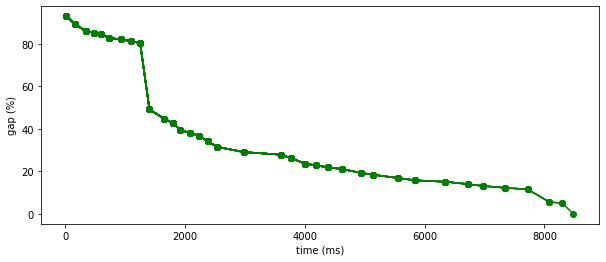

In [79]:
m9 = build_hearts(10)
m9.add_progress_listener(MipGapPlotter())
m9.solve(clean_before_solve=True);

## Sonuç ##
Bu eğitimimizde, Listeners (Dinleyiciler) ile modellerimizi nasıl takip edebileceğimizi, limit vererek nasıl durdurabileceğimizi, tüm çözümleri nasıl inceleyebileceğimizi gibi bir çok şey öğrendik. Bir sonraki eğitimde görüşmek üzere.

__Sabri Suyunu__